In [21]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import pylab as plb
import csv
from scipy import optimize
from scipy import asarray as ar,exp
from scipy import odr
from scipy.constants import hbar, m_p, e, h, m_e, pi

plt.style.use('untitled1.txt')

# Aims

# Determination of resonance magnetic field $B_0$ and g-factor for DPPH

## Aims

## Experimental Method

### Experimental set-up

ADD PHOTO?

We had Helmholtz coil: a pair of parallel coils of radius 6.8 cm, seperated from eachother by the same distance. When we run a current through them, we then generate an even magnetic field ($B_0$) through their centre. We place the DPPH sample at the centre of the coils, in an RF coil. We chose DPPH because it's unpaired electron on one of its Nitrogen atoms is unpaired, and behaves almost like a free electron, meaning it only has two energy states, spin up and spin down. The difference in energy between these two states depends on the magnetic field $B_0$ such that

$$E = g_s \mu_B B_0 m_s$$

where $m_s$ is the spin quantum number (equals $\pm 1/2$), $\mu_B$ is the Bohr magneton and $g_s$ is the g-factor for DPPH, assuming the electron behaves like a free electron. This is eq (5) in the lab script

We drive the RF coil using an oscillator in the MHz range, which means there will be incoming photons of these energies on the sample. If the energy of the incoming photons matches the energy difference between the spin up and spin down states, the electron will absorb this photon and the spin will flip. This will decrease the impedence of the coil, as we lose energy, which then causes a dip in the voltage which we can measure and view on the oscilloscope. This is the resonance dip.

We can then study this resonance and therefore calclate the g-factor dring the spin-flip transition.


### Calibration

Before we start, we need to calibrate the Helmholtz coils, as described in appendix 4 in the lab script. We do this because we only measure the current we put in these coils, not the magnetic field. So we want to be able to convert between the two, because the latter is what we want. To do this, we measure the magnetic field at the centre of the coils, and increase the current at different steps, noting down both values. The relationship should be linear according to equation (6) in the lab script, so we want to fit a straight line through the data. I'll measure for increasing (direct) current from $0.1$ to $1.2 \, \mathrm{A}$ in $0.1\, \mathrm{A}$ steps.

Putting hall probe in place:
- It's a magnetic fieldhere, so a vector. Means that orientation / position matters. I can't get orientation quite right because of clamp. We'll see if it's ok after the data analysis.
- negative/positive sign for magnetic field indicates the direction of the current (rh rule)


This is probably where we will get the most systematic error, for example by incorrectly placing the hall probe, or when adjusting the $0$ value. The calibration must also be good because a bad one adds more error when converting from $I$ to $B_0$.

I estimate the error on current to be $0.001 \mathrm{A}$ and $0.02 \mathrm{mT}$ for the magnetic field, because this is how much these values would wobble around when taking the measurement.

I forgot to set the Hall probe to $0 \mathrm{mT}$ outside field (meant I had an offset), so I had to start again :( . There may be a magnetic field in the lab (for example, Earth's magnetic field is $\sim 0.05 \mathrm{mT}$), but setting it to 0 outside the coils takes care of that (like doing the tare weight on food scales).

I redid the measurements again for increased accuracy.

The calibration should be a straight line, as the current and magnetic field are related according to eq (6) in the lab script

$$B_0 = \mu_0 \left(\frac{4}{5} \right) ^ {3/2} \frac{n}{r} I$$

where $\mu_0$ is the permeability of free space, $n$ is the number of turns per coils and $r$ is the radius of the coils (6.8 cm here).

We can fit a straight line using `optimize.curve_fit`, which uses the method of least squares.

In [22]:
#load the data and sort them 
data=np.loadtxt('ESR_calibration.txt',skiprows=1, usecols = (0, 1))
current=data[::,0]
B_0=data[::,1]
errorI= 0.001
errorB=0.02

the best fit line would be: y = 3.667x + -0.026
where the error on the slope is 0.012,
and where the error on the intercept is 0.009.
We therefore get the following graph:


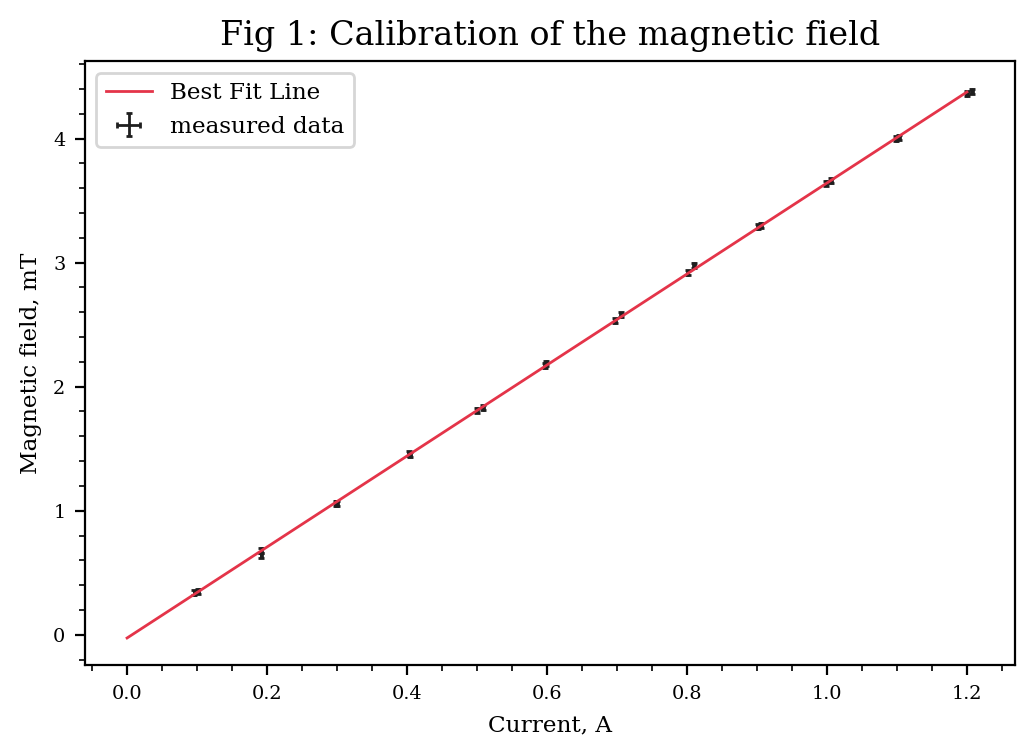

In [45]:
#define the equation for a linear fit
def linear_function(x,m,c):
    return m*x+c

p, p_cov = optimize.curve_fit(linear_function, current, B_0 , sigma = errorB*np.ones_like(B_0), absolute_sigma=True)
    
    #parameters of the fit function
fitted_m = p[0]
fitted_c = p[1]

#error in the parameters are the square root of the diagonal of the covariant matrix
err_fitted_m = np.sqrt(p_cov[0,0])
err_fitted_c = np.sqrt(p_cov[1,1])

#printing the equation
print('the best fit line would be: y = {0:.3f}x + {1:.3f}'.format(fitted_m,fitted_c))
print('where the error on the slope is {0:.2g},'.format(err_fitted_m))
print('and where the error on the intercept is {0:.1g}.'.format(err_fitted_c))


#plotting
print('We therefore get the following graph:')

    #independant variable, to complete
x = np.linspace(0,1.2)

    #original values
plt.errorbar(current, B_0, xerr = errorI*np.ones_like(current), yerr=errorB*np.ones_like(B_0), fmt='none', label = 'measured data')

    #best fit
plt.plot(x,linear_function(x, fitted_m, fitted_c), label= 'Best Fit Line')
plt.legend()
plt.xlabel('Current, A')
plt.ylabel('Magnetic field, mT')
plt.title('Fig 1: Calibration of the magnetic field')
plt.savefig('ESR_current_calibration.pdf')
plt.show()

This is a very good fit as there are no outlying data points. Rewriting the calibration equation for clarity, we have

$$B_0 = (3.667 \pm 0.012 \, \mathrm{mT/A}) I - (0.026 \pm 0.009 \, \mathrm{mT})$$

However, although the fit seems very good, the value for the slope is not consistent with what we should have found. Indeed, as $n = 320$, the slope should be equal to $4.23$, which is quite far from our value ($-13 \%$ difference). Some of this could come from the existence of the offset, but not much, as it is very small. Some small error may have been introduced by assuming the relative permeability of air is 1 and that the radius is exactly 6.8 cm. Another possibility is that the Helmholtz coils were not placed exactly 6.8 cm appart, which would have modified the initial relation. The most likely cause, however, is the placement of the Hall probe. Firstly, the magnetic field inside the Helmholtz coil is not completely uniform, and changes depending on the distance to the coil. This may have contributed a small amount, but for it to have contributed fully, we would need the measured magnetic field to be $1.15$ times that of the value at the centre, but I can guarantee you that it wasn't that close to the coils. See figure 2 taken from https://en.wikipedia.org/wiki/Helmholtz_coil#/media/File:Helmholtz_coil,_B_magnitude_cross_section.svg .

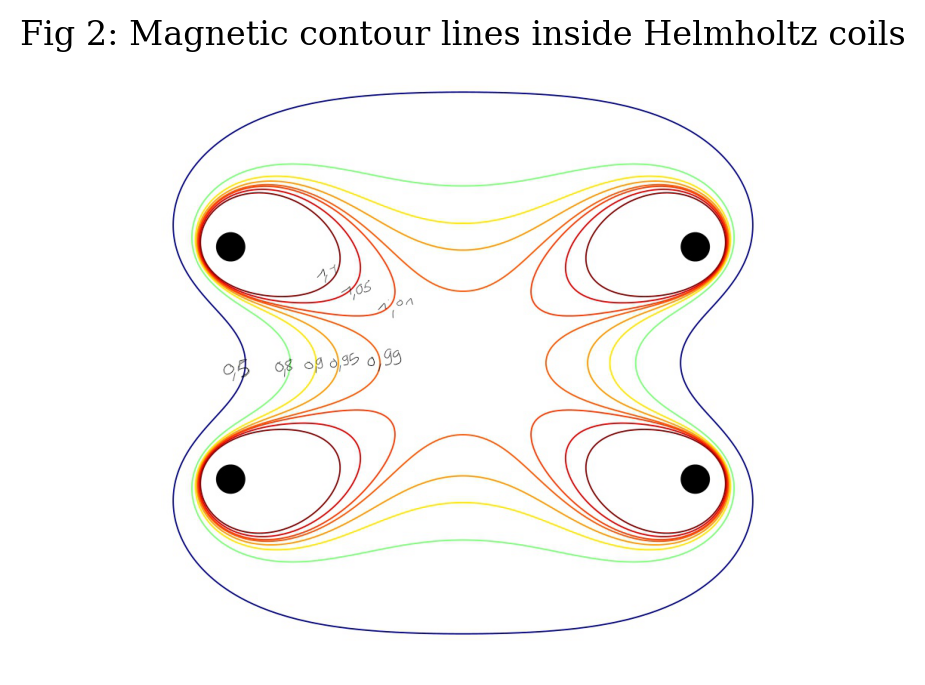

In [46]:
coils = plt.imread('Helmholtz_coil.png')
plt.figure(figsize=(6,4))  # Sets the size of the displayed image
plt.imshow(coils)
plt.axis('off')
plt.title('Fig 2: Magnetic contour lines inside Helmholtz coils')
plt.show()

Here, I annotated the image to show the value of the contour lines, in units of $B_0$. Further, as I tried placing the probe as close as possible to where the sample and RF coil would be, all this shouldn't matter too much. This could also come from the orientation of the probe (i.e. how much it faced the magnetic field lines).

### Determining the g-factor of DPPH

WHAT DO YOU WANT??? Explain with photo of oscilloscope.

We needed tabulated data of $I$ and frequency $\nu$ for the small, medium and large coils. These cover different frequency ranges, with the largest coil covering the lowest frequencies and the smallest covering the greatest frequencies.

I followed what was in the lab script. Changing DC current so that peaks (ESR signal) coincide with sine wave (B signal) when it crosses 0, as the average of the sine wave is basically the non-modulating magnetic field $B_0$, and we want the resonnance frequency to coincide with this. In the 2-channel display, I get signals similar to figure ???

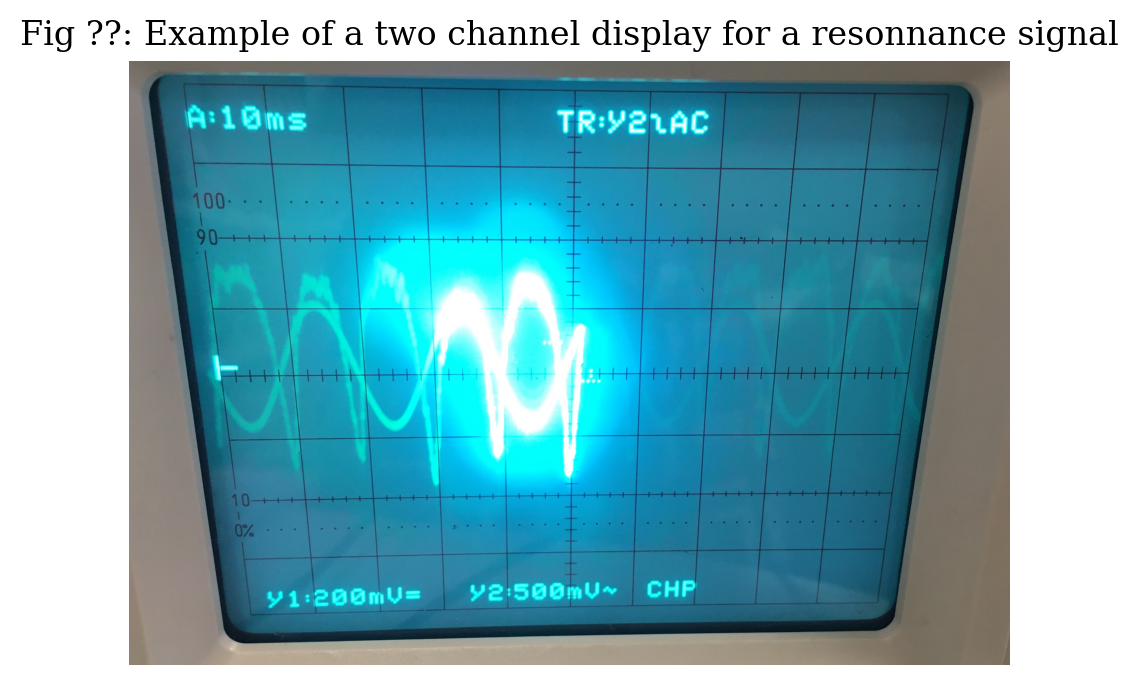

In [54]:
twochannels = plt.imread('ESR_2channels.png')
plt.figure(figsize=(6,4))  # Sets the size of the displayed image
plt.imshow(twochannels)
plt.axis('off')
plt.title('Fig ??: Example of a two channel display for a resonnance signal')
plt.show()

It's a bit hard to see what actually happens in figure ??? because my phone camera has a smaller exposure time than the time it took for the signal to fill the screen. But we can still see the resonnance dips seperated by an equal distance, which corresponds to $0$ in the modulated magnetic field. When we go to the **XY** mode, we get figure ??

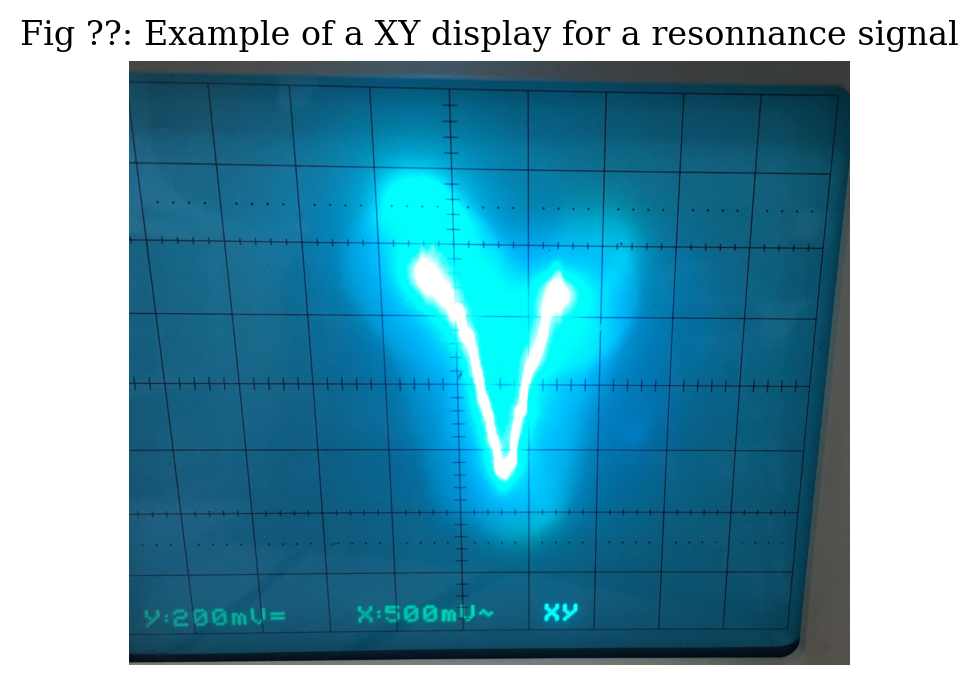

In [55]:
XY = plt.imread('ESR_XY.png')
plt.figure(figsize=(6,4))  # Sets the size of the displayed image
plt.imshow(XY)
plt.axis('off')
plt.title('Fig ??: Example of a XY display for a resonnance signal')
plt.show()

Here, we collapsed the resonance peaks into one. This should be symmetrical. However, it was hard to adjust the DC current so that became so. However, this is included in the error on the current. This may be a Lorentzian.

When I reached 30MHz, I changed large coil to medium one.

Hard to make things symmetric, but still beyond the precision so not too serious (rephrase). See error estimates later on. Partly because 'I=' toggle not very sensitive, hard to adjust finely.

I sometimes had to wait a bit for the frequency to settle down.

I couldn't reach 75 MHz for medium coil (would begin decreasing before I could), so had to do this measurement with smallest coil.

Had to increase AC current to widen peak for 75 MHz. Peak doesn't look sharp at all PHOTO. did as best I could. But gets sharper as I increase the current. Perhaps has to do with the fact it's at the edge on the measuring range. 

Also had trouble for 95MHz and 100MHz. The current for the two is quite close, which might be because I fiddled, or because my measurements were bad because I wasn't quite sure when the peak was symmetric.

Couldn't get 130MHz because it keeps bouncing back

Measurements not very good e.g. for 95 and 100 MHz, so I'm going to repeat them to reduce random error because of how hard it was to get the peak to be symmetrical.

I estimate the error on current to be about 0.005A, because this is how much the current changed when I tried adjusting the current to get a symmetric peak
I estimate the error on frequency to be 0.1MHz because this is how precise the oscillator is.

To find the g-factor for DPPH (which should be the Lande factor), we basically use the same method as in part 2 of the NMR, part, ie we rearrange equation (5) in the lab script to get

$$g_s = \frac{\mu_B}{h} \frac{B_0}{\nu}$$

where $\mu_B$ is the Bohr magneton, $\frac{e \hbar}{2m_e}$, and so calculate the slope of $B_0$ against $\nu$ which would be $\frac{B_0}{\nu}$.

We first want to convert the magnetic field, as we only have the current values.

In [25]:
#upload the data
data = np.loadtxt('ESR_part1.txt', skiprows=1, usecols = (0,1))
I    = data[::,0]
f    = data[::,1]

#calculate the values for B using calibration and put then in an array
B=[]
for i in I:
    mag=(fitted_m*i+fitted_c)
    B.append(mag)

#error on frequency
f_err=0.1*np.ones_like(f)

#propagate the error from the best fit and the measurements, then put the values in an array
B_err=[]  #this is the error coming from the fit
for i in I:
    a         = fitted_m*i                                          #slope*current
    a_err     = a*np.sqrt((errorI/i)**2+(err_fitted_m/fitted_m)**2) #error for slope*current
    b_err_val = np.sqrt(a_err**2+(err_fitted_c)**2)                 #error for slope*current + offset
    
    B_err.append(b_err_val)

Now we can do an orthogonal distance reduction fit (using the `scipy` function `odr`) to fit a straight line through the frequency against magnetic field. This is not what is recommended in the lab script (method of least squares) but we thought this would be better as the function takes a standard error in the independant variable.

running the fit:
Beta: [28.1125474   0.51242822]
Beta Std Error: [0.17755466 0.41565051]
Beta Covariance: [[ 0.00226315 -0.00467885]
 [-0.00467885  0.01240241]]
Residual Variance: 13.92998623025652
Inverse Condition #: 0.1632157543320371
Reason(s) for Halting:
  Sum of squares convergence


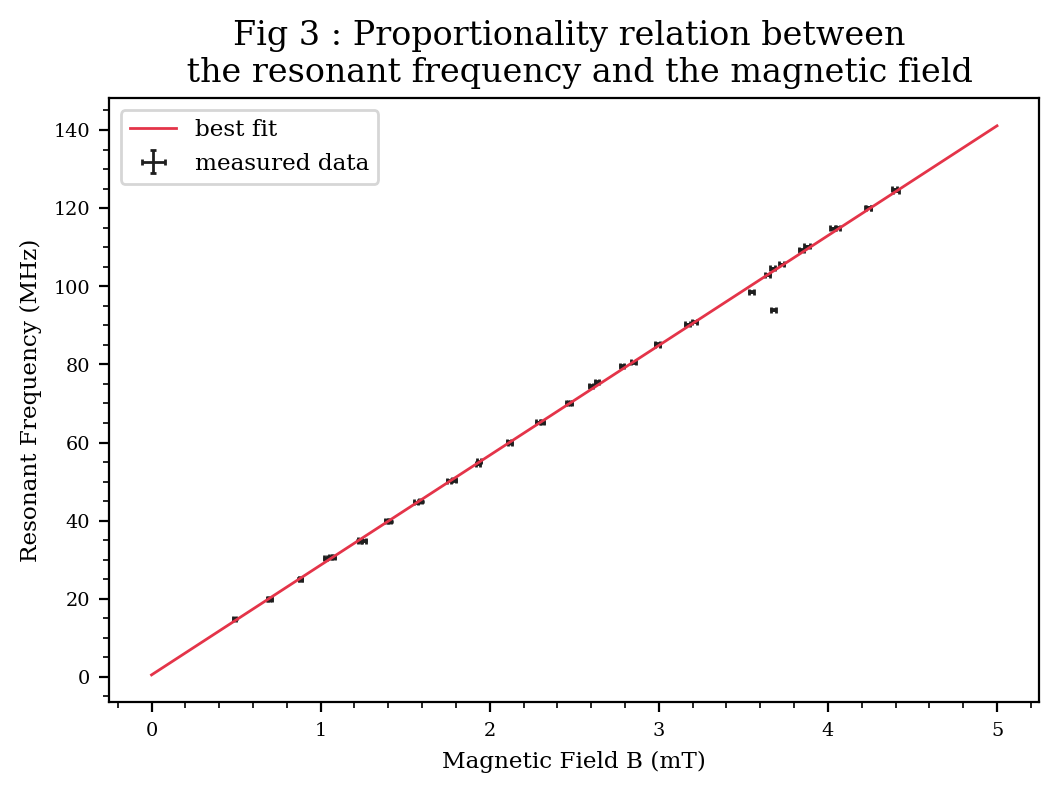

In [47]:
 #do the odr
dat = odr.RealData(B, f, sx = B_err, sy = f_err )

        # Set up ODR with the model and data.
fit = odr.ODR(dat, odr.unilinear, beta0 = [1, 1]) #initial guesses to update

        # Run the regression
out = fit.run()

        # Use the in-built pprint method to give us results.
print('running the fit:')
out.pprint()
    
        #define arrays for parameters
slope, increment         = out.beta
err_slope, err_increment = out.sd_beta
x=np.linspace(0,5)

#plot the data and best fit
plt.errorbar(B,f, xerr=B_err, yerr=f_err,fmt='none', label='measured data')
plt.plot(x, slope*x+increment, label='best fit')
plt.xlabel('Magnetic Field B (mT)')
plt.ylabel('Resonant Frequency (MHz)')
plt.title('Fig 3: Proportionality relation between \n the resonant frequency and the magnetic field')
plt.legend()
plt.savefig('f_B.pdf')
plt.show()

This means the straight line fit would be

$$\nu = (28.11 \pm 0.18) B_0 + (0.5 \pm 0.4)$$

Looking at figure 3, and at the standard deviation on the parameters, we can see that the fit matches the data very well. Only one point is very far from the curve (at $\nu = 94$). This was expected, as it was a measurement I had trouble making. 

The error in the offset is very small compared to the frequency (less than $1\%$), contrary to zhat we had in the nmr part, and so we will ignore the offset. It is probably due to the two points that are far from the curve around $B_0 = 3.8 \, \mathrm{mT}$, as taking tham away would tilt the curve and take the offset away.

This would mean

$$\frac{\nu}{B_0} = (28.11 \pm 0.18) $$

Now calculating the value for the Lande g-factor, rearranging the equation derived previously into

$$g_s= \frac{\nu}{B_0} \frac{h}{\mu_B}=  \frac{\nu}{B_0} \frac{2 h m_e}{\hbar e}=\frac{\nu}{B_0} \frac{4\pi m_e}{e}$$

In [27]:
g_s=(4*slope*pi*m_e/e)*10**9  #multiplying by 10^9 since frequency is in MHz and B in mT

#calculate error
g_err=(err_slope/slope)*g_s

print('Our value for g-factor is {0:.3f} pm {1:.2g}.'.format(g_s,g_err))

Our value for g-factor is 2.009 pm 0.013.


# Determination of the half-width $\delta \mathrm{B_0}$ for DPPH

## Aims

## Experimental Methods

### Calibration (if different)

### Calculating half-width

Same set up as part 1. I chose the medium coil to use for 50MHz resonance peak.

I adjusted everything as described in lab script, choosing the XY mode on the oscillator.

Measure $I_{mod}(\mathrm{RMS})=0.285 \mathrm{A}$ once I extended the signal to 10cm in the X-axis.

Adjusted background to be on a line (1/4 of the screen down) for 500mVx500mV graph so that peak could be easily readable, as seen on photo ADD NAME!

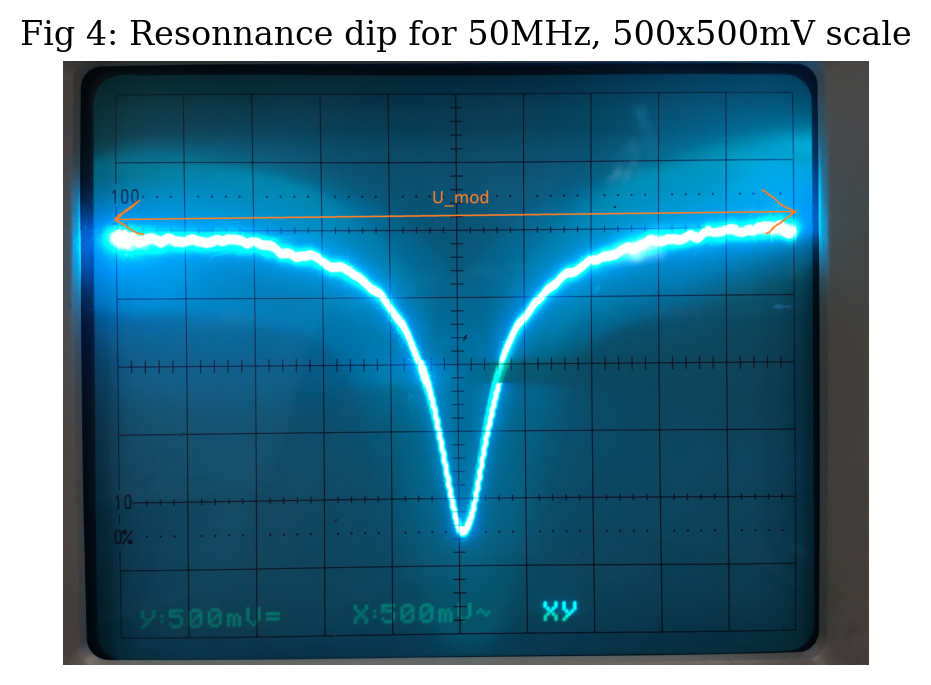

In [50]:
firstphoto = plt.imread('500x500mV.png')
plt.figure(figsize=(6,4))  # Sets the size of the displayed image
plt.imshow(firstphoto)
plt.axis('off')
plt.title('Fig 4: Resonnance dip for 50MHz, 500x500mV scale')
plt.show()

This absorption dip is clearly a Lorentzian, as expected for spin flip transitions.

Widened the scale in the x-axis (decreased to 200mV/cm) to better read the half width during the analysis, as seen in picture: (ADD TITLE+NUMBER)

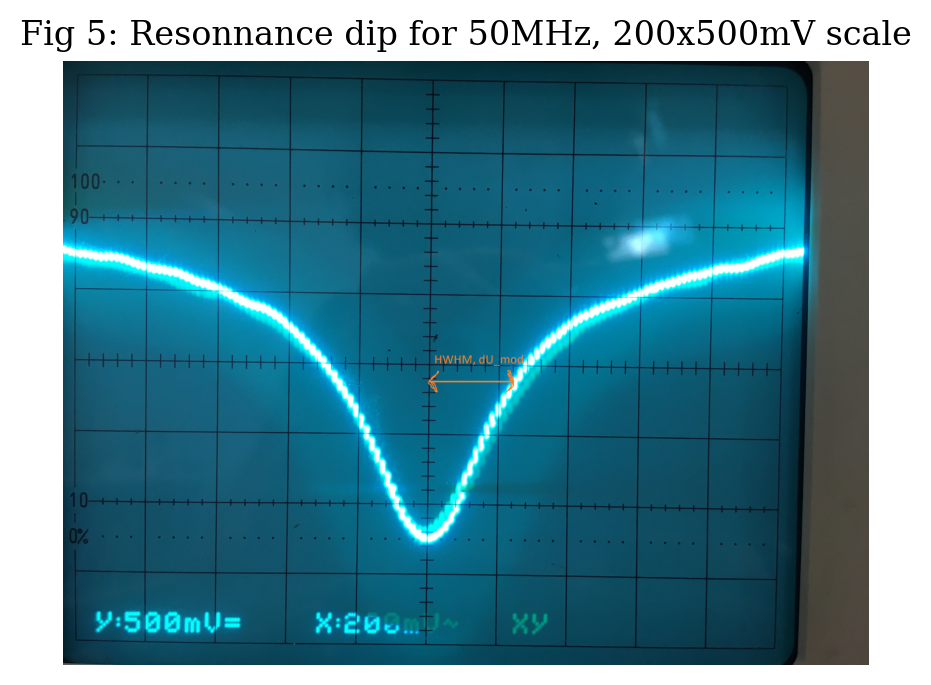

In [52]:
secondphoto = plt.imread('200x500mV.png')
plt.figure(figsize=(6,4))  # Sets the size of the displayed image
plt.imshow(secondphoto)
plt.axis('off')
plt.title('Fig 5: Resonnance dip for 50MHz, 200x500mV scale')
plt.show()

In this part, we want to calculate the half-width of the absorption peak. We first need to estimate the full modulation voltage $U_mod$ (U_mod in figure 4) and the half-width at half-maximum $\delta U$ (dU_mod in figure 5). We see that

$$U_{mod} = 5 \, \mathrm{V}$$

and

$$\delta U = 0.22 \, \mathrm{V}$$

We can then convert this to current by doing (eq 7 in lab script)

$$\delta I = \frac{\delta U}{U_{mod}} I_{mod}$$

But $I_{mod} = 2 \sqrt{2} I_{mod}(\mathrm{RMS})$, so

$$\delta I = 2 \sqrt{2} \frac{\delta U}{U_{mod}} I_{mod}(\mathrm{RMS})$$

In [30]:
#measured values in lab
I_mod = 0.285 #ampers
U_mod = 5     #u_mod=volts/cm *10cm scale
dU    = 0.22  # volts * measured halfwidth

#estimated errors
I_mod_err = 0.001
dU_err    = 0.02   #from graduation marks

#calculation of dI
dI=dU*I_mod/U_mod*2*np.sqrt(2)
dI_err=np.sqrt((I_mod_err/I_mod)**2+(dU_err/U_mod)**2)*dI

#print the statement
print('The value of dI is {0:.4f} pm {1:.1g}.'.format(dI,dI_err))

The value of dI is 0.0355 pm 0.0002.


Converting to magnetic field values, using our calibration (we don't need a new one because we already did it previously)

In [33]:
#calculation of dB using our calibration
dB = fitted_m*dI+fitted_c

#error propagation as in part 1
a      = fitted_m*dI
a_err  = a*np.sqrt((dI_err/dI)**2+(err_fitted_m/fitted_m)**2)
dB_err = np.sqrt(a_err**2+(err_fitted_c)**2)

#print the statement
print('The value of dB is {0:.3f} pm {1:.1g} mT.'.format(dB,dB_err))

The value of dB is 0.104 pm 0.009 mT.


The corresponding magnetic field value can be found by using:

$$B_0 = \frac{h \nu}{g_s \mu_B}$$

where $\nu = 50 \, \mathrm{MHz}$ here, and using our value for $g_s$.

In [44]:
B_50MHz = h * ((2*m_e)/(hbar*e)) * (50e6/g_s)

# error propagation


B50_err = B_50MHz * np.sqrt((0.1e6/50e6)**2+(g_err/g_s)**2)

#print the statement
print('The value of the magnetic field at 50MHz is {0:.3f} pm {1:.2g} mT.'.format(B_50MHz*10**3, B50_err*10**3))

The value of the magnetic field at 50MHz is 1.779 pm 0.012 mT.


# Results

For the ESR part, we finally get that our value for the Landé g-factor is

$$g_s = 2.009 \pm 0.013$$

This is close to the litterature value for DPPH of $2.0036$ (DOI 10.4010/2016.884), as there is a difference of $0.3 \%$. Furthermore, as the two values are within one standard deviation away from eachother, they are in reasonable agreement. Our error may be an underestimate, as we did not count the offset in figure 3.

Furthermore, we find that for DPPH, the magnetic field at the resonant frequency $50 \, \mathrm{MHz}$ is $1.779 \pm 0.012 \, \mathrm{mT}$, and the dip has a half-width at half-maximum of $0.104 \pm 0.009 \, \mathrm{mT}$.

# Discussion and Conclusion

lorentzian, theoretical value for half width: https://en.wikipedia.org/wiki/Full_width_at_half_maximum

https://en.wikipedia.org/wiki/Cauchy_distribution

Comparision with litterature for half width value

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6175221/